# Introduction
In this project we analyze the IMDB and Box Office Mojo datasets in order to give management recommendation on the types of movie they can invest in to enter the movie production industry.

First, we answer a high-level question, are high quality movies also profitable? Then we examine metrics of movie performance (profitability, worldwide gross revenue, production budget)  aggregated over 10-year period by genre, to uncover the best genres to invest in.

In the second part of analysis, based on findings from part one of the analysis, we decide to take a deeper dive into two movie genres (Horror and Adventure), and make specific recommendations on the actions the Company should puruse given different objectives.

# Part I - High Level Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
df = pd.read_csv('cathy/data/title_budgets_ratings_v3.csv', index_col = 0)

In [3]:
df.head()

,id,release_date,movie,tconst,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,year,month,production_budget_2,domestic_gross_2,worldwide_gross_2,genres2,profit_multiple
0,1,2009-12-18,Avatar,tt1775309,Avatar,Abatâ,2011,93.0,Horror,6.1,43,2009,12,425000000,760507625,2776345279,['Horror'],5.532577
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.0,"Action,Adventure,Fantasy",6.6,447624,2011,5,410600000,241063875,1045663875,"['Action', 'Adventure', 'Fantasy']",1.546673
2,3,2019-06-07,Dark Phoenix,tt6565702,Dark Phoenix,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,24451,2019,6,350000000,42762350,149762350,"['Action', 'Adventure', 'Sci-Fi']",-0.572108
3,4,2015-05-01,Avengers: Age of Ultron,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",7.3,665594,2015,5,330600000,459005868,1403013963,"['Action', 'Adventure', 'Sci-Fi']",3.243841
4,7,2018-04-27,Avengers: Infinity War,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,670926,2018,4,300000000,678815482,2048134200,"['Action', 'Adventure', 'Sci-Fi']",5.827114


## Relationship between profitability and movie rating
First, we investigate if high movie rating correlates with high profitability for 2943 movies that have gross box office and budget data. 

Our profitability is defined as:
$Profitability multiple = \dfrac{(worldwide gross - production budget)}{production budget}$

In [4]:
# Decision around Nulls
df.isna().sum()

id                       0
release_date             0
movie                    0
tconst                   0
primary_title            0
original_title           0
start_year               0
runtime_minutes        121
genres                   8
averagerating            0
numvotes                 0
year                     0
month                    0
production_budget_2      0
domestic_gross_2         0
worldwide_gross_2        0
genres2                  8
profit_multiple          0
dtype: int64

In [5]:
# We won't drop rows with null in 'runtime_minutes' because 
# some big productions, such as Titanic, are missing value.
df.loc[df['movie']== 'Titanic']

,id,release_date,movie,tconst,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,year,month,production_budget_2,domestic_gross_2,worldwide_gross_2,genres2,profit_multiple
32,43,1997-12-19,Titanic,tt2495766,Titanic,Titanic,2012,NaN,Adventure,6.2,20,1997,12,200000000,659363944,2208208395,['Adventure'],10.041042


In [6]:
# Drop the 282 productions where worldwide gross revenue is zero.
df = df[df['worldwide_gross_2']!=0]

# Drop 43 productions that have profit multiple over 30.
df = df[df['profit_multiple']<= 30]

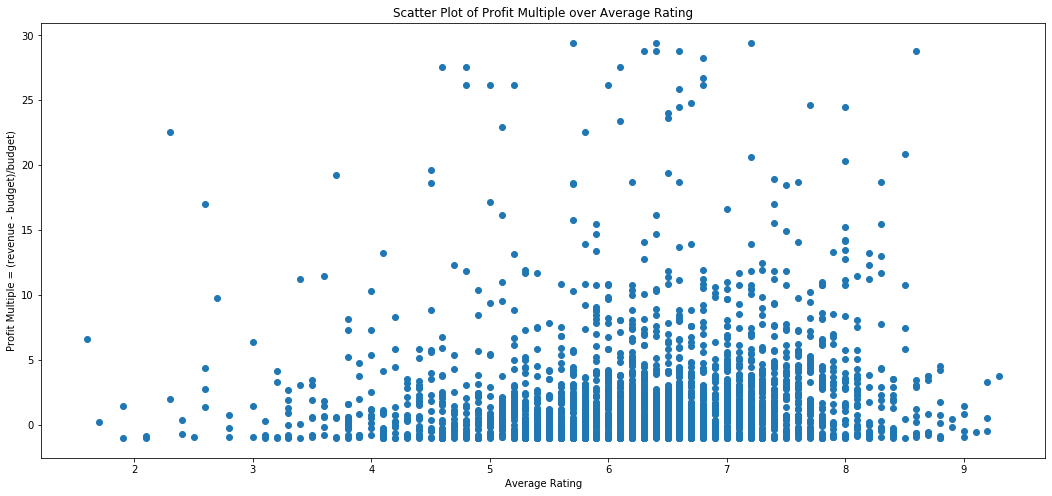

In [40]:
fig = plt.figure(figsize = (18,8))
plt.scatter(df['averagerating'], df['profit_multiple'])
plt.title('Scatter Plot of Profit Multiple over Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Profit Multiple = (revenue - budget)/budget)')
plt.show()

We see a positive correlation between movie profitability and the rating they receive. 

## Gross revenue and profitability by genre

In [8]:
# Split genre strings as list of genres. 
df['genres3'] = list(df['genres'].str.split(','))

In [9]:
# Drop the 8 movies where genres are null.
df = df.dropna(subset = ['genres3'])

In [10]:
df.shape

(2610, 19)

In [11]:
# define function get_genres that takes df and returns avg_revenue, avg_profit, avg_budget for a given genre. 

def get_genres(df, genre):
    revenue_list = []
    profit_list = []
    budget_list = []
    for i in range(len(df)):
        if genre in df['genres3'].iloc[i]:
            revenue_list.append(df['worldwide_gross_2'].iloc[i])
            profit_list.append(df['profit_multiple'].iloc[i])
            budget_list.append(df['production_budget_2'].iloc[i])
    avg_revenue = round(sum(revenue_list)/len(revenue_list),2)
    avg_profit = round(sum(profit_list)/len(profit_list),2)
    avg_budget = round(sum(budget_list)/len(budget_list),2)
    return avg_revenue, avg_profit, avg_budget, genre

In [12]:
# create a list of unique genres.
genres_unique =[]
for i in range(len(df)):
    for n in range(len(df['genres3'].iloc[i])):
        if df['genres3'].iloc[i][n] not in genres_unique:
            genres_unique.append(df['genres3'].iloc[i][n])
genres_unique

['Horror',
 'Action',
 'Adventure',
 'Fantasy',
 'Sci-Fi',
 'Thriller',
 'Western',
 'Animation',
 'Comedy',
 'Family',
 'Crime',
 'Drama',
 'Musical',
 'Romance',
 'Mystery',
 'Documentary',
 'Biography',
 'History',
 'Sport',
 'War',
 'Music',
 'News']

In [13]:
# We make a new DataFrame, df_genre, to store all genre types and their revenue and profit multiples. 
genres_list = []
for i in genres_unique:
    genres_list.append(list(get_genres(df,i)))
df_genre = pd.DataFrame(genres_list, columns=['revenue', 'profit', 'budget', 'genre'])

In [14]:
# set genre as index: 
df_genre = df_genre.set_index('genre')

In [15]:
# Sort genres by average revenue.
df_genre_rev = df_genre.sort_values(by=['revenue'], ascending = False)['revenue']

In [16]:
# Convert revenue unit to millions. 
df_genre_rev = df_genre_rev/1000000 

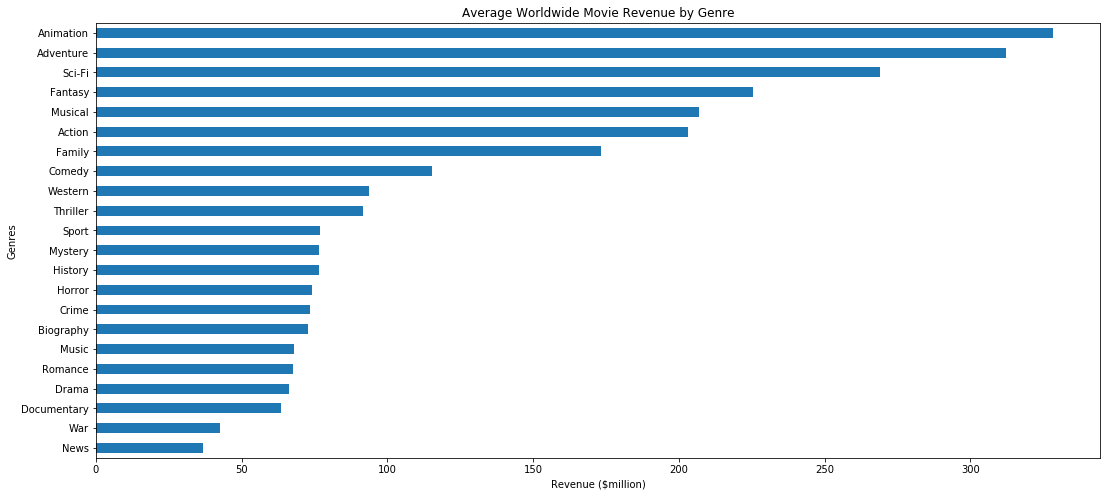

In [17]:
# Plot revenue by genre in descending order: 
plt.figure(figsize = (18,8))
df_genre_rev.plot.barh()
plt.title('Average Worldwide Movie Revenue by Genre')
plt.xlabel('Revenue ($million)')
plt.ylabel('Genres')
plt.gca().invert_yaxis()
plt.show()

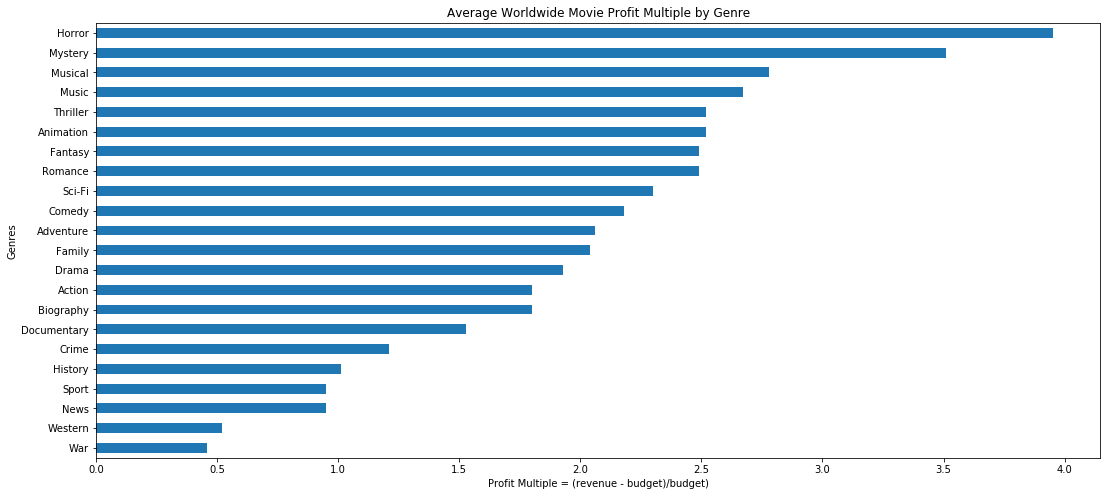

In [18]:
# Plot bar charts for profitability and average budget: 
df_genre_profit = df_genre.sort_values(by=['profit'], ascending = False)['profit']

plt.figure(figsize = (18,8))
df_genre_profit.plot.barh()
plt.title('Average Worldwide Movie Profit Multiple by Genre')
plt.xlabel('Profit Multiple = (revenue - budget)/budget)')
plt.ylabel('Genres')
plt.gca().invert_yaxis()
plt.show()

## Closer look at Profit and Revenue trends of top-performing genres
Horror genre stood out as having low production budgets on average and earning the top profit multiple! We take a closer look at Horror movies' profitability trends over years, and compare it to all other genres. 

In [19]:
# First we break out each genre into separate rows. This gives us 5930 rows to work with. 
df2 = df.explode('genres3')
df2.shape

(5930, 19)

In [20]:
# Calculate the average profit multiple by genre and year, save in df3.
df3 = df2.groupby(['genres3','start_year'])['profit_multiple'].mean()

In [21]:
# Exclude Horror genre and save in df4. 
df4 = df3.reset_index(level=['genres3','start_year'])
df4 = df4[df4['genres3'] != 'Horror']
df4

,genres3,start_year,profit_multiple
0,Action,2010,1.483806
1,Action,2011,2.299466
2,Action,2012,1.849022
3,Action,2013,1.349947
4,Action,2014,2.334794
...,...,...,...
200,Western,2014,-0.096994
201,Western,2015,-0.849146
202,Western,2016,0.805835
203,Western,2018,-0.947879


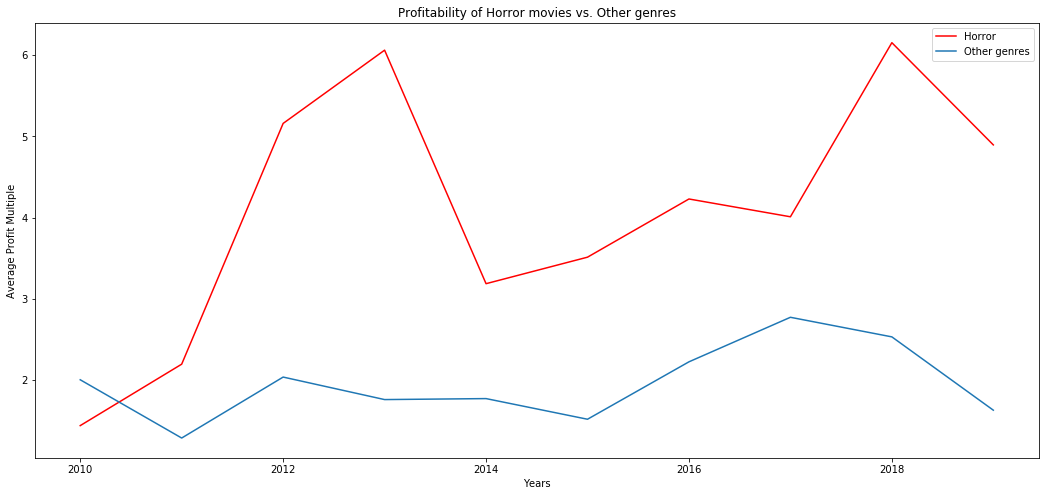

In [22]:
# Then we plot the average profit multiple for Horror movies vs. all other genre types over time
df4 = df3.reset_index(level=['genres3','start_year'])
df4 = df4[df4['genres3'] != 'Horror']

plt.figure(figsize = (18,8))
plt.plot(df3.Horror, color = 'red', label = 'Horror')
plt.plot(df4.groupby(['start_year'])['profit_multiple'].mean(), label = 'Other genres')
plt.title('Profitability of Horror movies vs. Other genres')
plt.xlabel('Years')
plt.ylabel('Average Profit Multiple')
plt.legend()
plt.show()

We also look at the top revenue-generating genre, Adventure, and compare its average revenue to all other genres. 

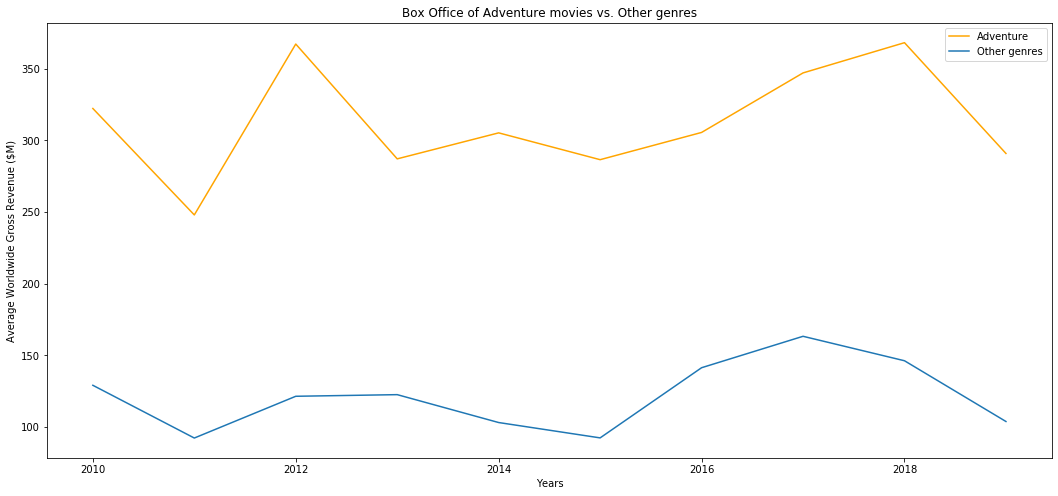

In [23]:
# Plot the average revenue of Action movies vs. all other genres over years. 

# Calculate the average revenue by genre and year, save in df5.
df5 = df2.groupby(['genres3','start_year'])['worldwide_gross_2'].mean()

df6 = df5.reset_index(level=['genres3','start_year'])
df6 = df6[(df6['genres3'] != 'Adventure')]

plt.figure(figsize = (18,8))
plt.plot(df5['Adventure']/1000000, color = 'orange', label = 'Adventure')
plt.plot(df6.groupby(['start_year'])['worldwide_gross_2'].mean()/1000000, label = 'Other genres')
plt.title('Box Office of Adventure movies vs. Other genres')
plt.xlabel('Years')
plt.ylabel('Average Worldwide Gross Revenue ($M)')
plt.legend()
plt.show()

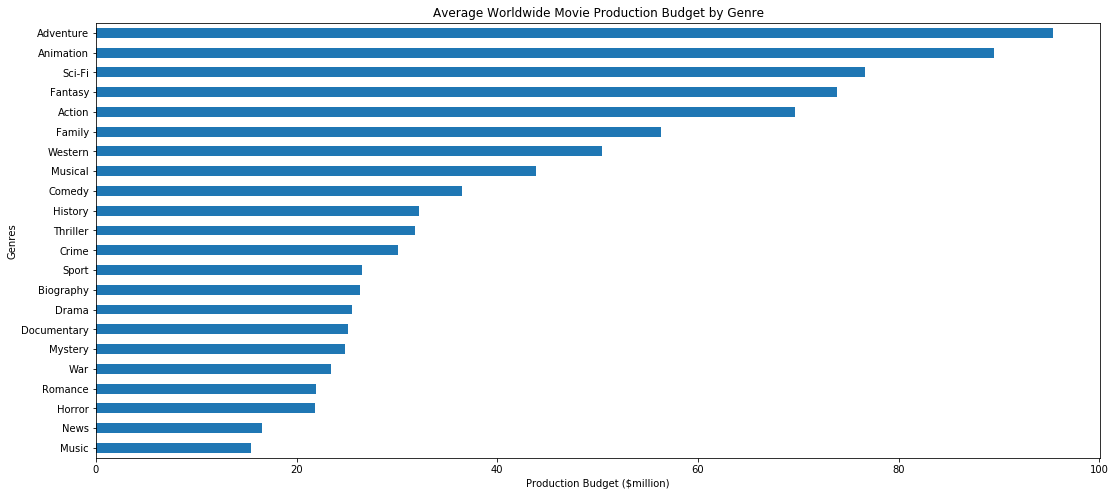

In [24]:
# Production budget by genre
df_genre_budget = df_genre.sort_values(by=['budget'], ascending = False)['budget']
df_genre_budget = df_genre_budget/1000000

plt.figure(figsize = (18,8))
df_genre_budget.plot.barh()
plt.title('Average Worldwide Movie Production Budget by Genre')
plt.xlabel('Production Budget ($million)')
plt.ylabel('Genres')
plt.gca().invert_yaxis()
plt.show()

# Part II - Actionable Insights

The above analysis shows that that Horror is by far the most profitable genre, and Adventure generates the most revenue (apart from Animation, which is a more difficult genre to analyze).  

Given this, we have decided to focus the rest of our efforts on the Horror and Adventure genres. Specifically, we have decided to drill down into the following areas to generate actionable insights:
#### Horror genre writer and director profitability
#### Adventure genre actor/actress and director revenue generation

In [25]:
#Create a seperate SQL query to pull data on directors, writers, actors, and actresses
import mysql.connector

con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')

df7 = pd.read_sql_query("""
SELECT primary_title, runtime_minutes, genres, averagerating, 
numvotes, ordering, category, job, characters, id, release_date, 
production_budget, domestic_gross, worldwide_gross, primary_name
FROM imdb_title_basics ba
JOIN imdb_title_ratings r ON ba.tconst = r.tconst
JOIN imdb_title_principals p ON p.tconst = ba.tconst
JOIN imdb_name_basics na ON na.nconst = p.nconst
LEFT JOIN movies.tn_movie_budgets bud ON bud.movie = ba.primary_title
""", con)

In [26]:
#Clean genre data
def get_genres(df7, genre):
    revenue_list = []
    profit_list = []
    for i in range(len(df)):
        if genre in df7['genres3'].iloc[i]:
            revenue_list.append(df7['worldwide_gross_2'].iloc[i])
            profit_list.append(df7['profit_multiple'].iloc[i])
    avg_revenue = sum(revenue_list)/len(revenue_list)
    avg_profit = sum(profit_list)/len(profit_list)
    return avg_revenue, avg_profit
df7['genres3'] = list(df7['genres'].str.split(','))

In [27]:
#Clean date data types
import datetime

df7['release_date'] = pd.to_datetime(df7['release_date'])
df7['year'], df7['month'] = df7['release_date'].apply(lambda x: x.year), df7['release_date'].apply(lambda x: x.month)

In [28]:
#Explode genre data into multiple rows
df7 = df7.explode('genres3')

In [29]:
#Drop null values
df_econ = df7.dropna(subset = ['production_budget', 'domestic_gross', 'worldwide_gross'])

In [30]:
#Disable jupyter warnings
import warnings
warnings.filterwarnings('ignore')

In [31]:
#Clean economic data
df_econ['production_budget'] = df_econ['production_budget'].str.replace('$','').str.replace(',','')
df_econ['domestic_gross'] = df_econ['domestic_gross'].str.replace('$','').str.replace(',','')
df_econ['worldwide_gross'] = df_econ['worldwide_gross'].str.replace('$','').str.replace(',','')

In [32]:
#Change economic data to floats
df_econ['production_budget'] = df_econ['production_budget'].astype(float)
df_econ['domestic_gross'] = df_econ['domestic_gross'].astype(float)
df_econ['worldwide_gross'] = df_econ['worldwide_gross'].astype(float)

In [33]:
#Calculate profit multiple
df_econ['profit_multiple'] = (df_econ.worldwide_gross - df_econ.production_budget) / df_econ.production_budget

In [34]:
#Limit data to people who have participated in at least 3 films
df_econ = df_econ[df_econ.groupby('primary_name').primary_name.transform(len)>6]

## Horror Genre Profitability - Writers and Directors

Our logic here: the popularity/ box office success of Horror movies is rarely tied to the actors/actresses in the film. Which directors and writers consistently produce the most profitable films?   

In [35]:
#Create dataframes for horror writers and directors
df_writers = df_econ.loc[df_econ['category']== 'writer']
df_directors = df_econ.loc[df_econ['category']== 'director']
df_horror_writers = df_writers.loc[df_writers['genres3']== 'Horror']
df_horror_directors = df_directors.loc[df_directors['genres3']== 'Horror']

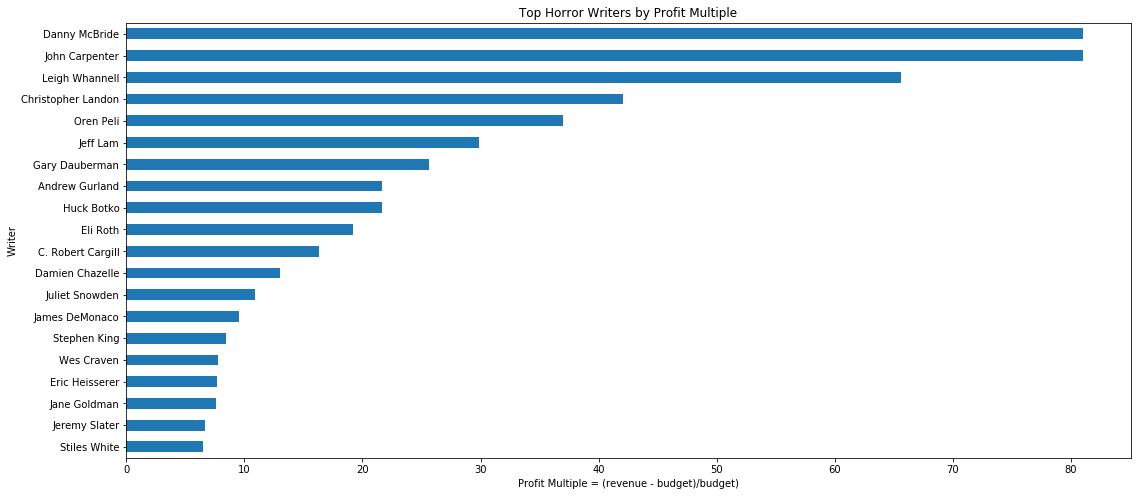

In [36]:
#Plot top 20
horror_writer_chart = df_horror_writers.groupby('primary_name')['profit_multiple'].mean().nlargest(20)

plt.figure(figsize = (18,8))
horror_writer_chart.plot.barh()
plt.title('Top Horror Writers by Profit Multiple')
plt.xlabel('Profit Multiple = (revenue - budget)/budget)')
plt.ylabel('Writer')
plt.gca().invert_yaxis()
plt.show()

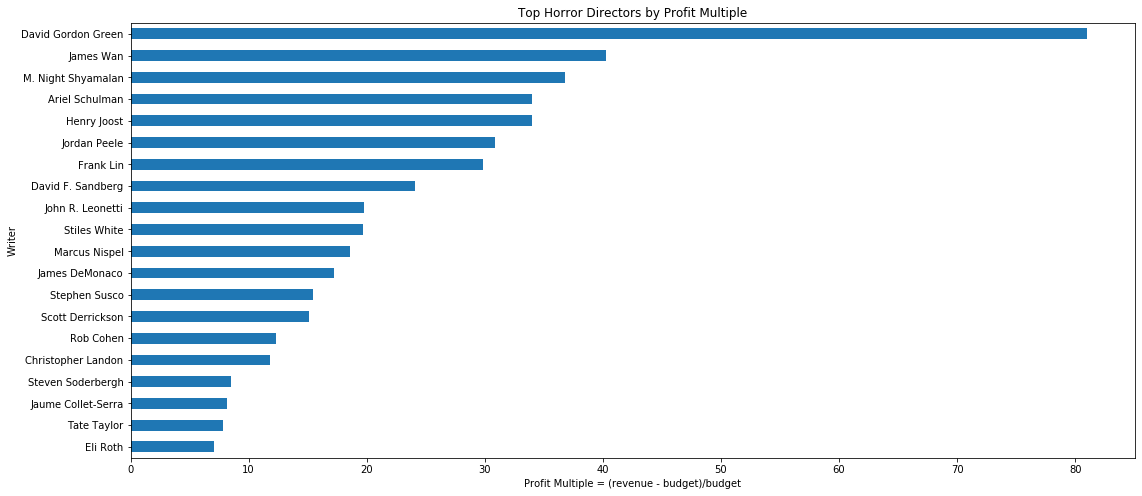

In [37]:
horror_director_chart = df_horror_directors.groupby('primary_name')['profit_multiple'].mean().nlargest(20)
plt.figure(figsize = (18,8))
horror_director_chart.plot.barh()
plt.title('Top Horror Directors by Profit Multiple')
plt.xlabel('Profit Multiple = (revenue - budget)/budget')
plt.ylabel('Writer')
plt.gca().invert_yaxis()
plt.show()

## Adventure Genre Revenue Generation - Actors/Actresses and Directors

Our logic here: Adventure films tend to have high profile actors/actresses and directors.  Which ones consistently participate in films that bring in the most revenue?

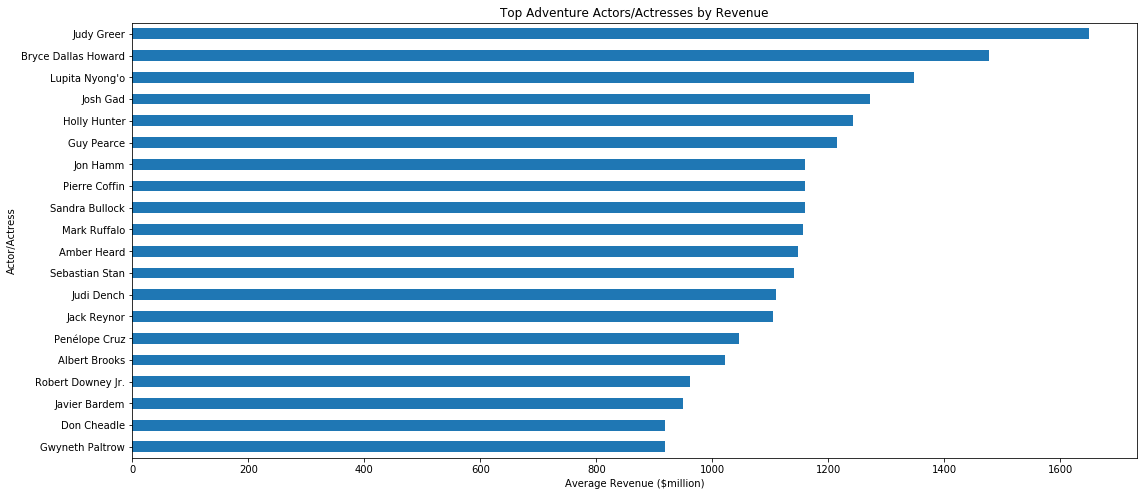

In [38]:
#Create Adventure actor/actress data frame
df_actors = df_econ.loc[(df_econ['category']== 'actor') | 
                        (df_econ['category']=='actress')]
df_adventure_actors = df_actors.loc[(df_actors['genres3']=='Adventure')]
adventure_actors_chart = df_adventure_actors.groupby('primary_name')['worldwide_gross'].mean().nlargest(20)
adventure_actors_chart = adventure_actors_chart/1000000

#Plot top 20 revenue generating actors/actresses
plt.figure(figsize = (18,8))
adventure_actors_chart.plot.barh()
plt.title('Top Adventure Actors/Actresses by Revenue')
plt.xlabel('Average Revenue ($million)')
plt.ylabel('Actor/Actress')
plt.gca().invert_yaxis()
plt.show()

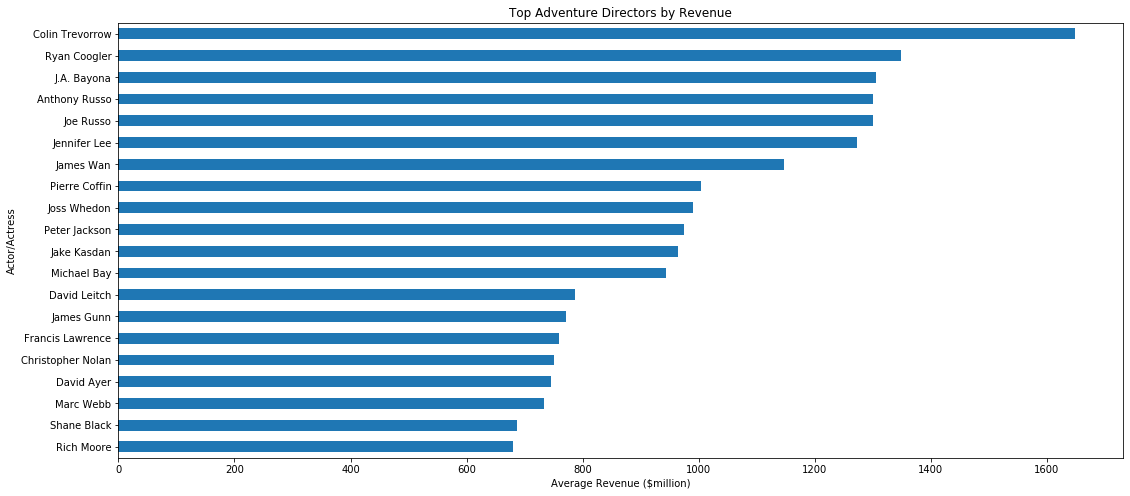

In [39]:
#Create Adventure directors data frame
df_adventure_directors = df_directors.loc[df_directors['genres3']== 'Adventure']
adventure_director_chart = df_adventure_directors.groupby('primary_name')['worldwide_gross'].mean().nlargest(20)
adventure_director_chart = adventure_director_chart/1000000

#Plot top 20 revenue generating directors
plt.figure(figsize = (18,8))
adventure_director_chart.plot.barh()
plt.title('Top Adventure Directors by Revenue')
plt.xlabel('Average Revenue ($million)')
plt.ylabel('Actor/Actress')
plt.gca().invert_yaxis()
plt.show()

# Conclusion

#### Depending on the risk profile of Microsoft, we recommend one of two paths:

1.  If the company is looking for more surefire profitability, they should pursue Horror films, and select a writer and a director from our above analyses.

2.  If the company is looking for top line box office success, they should pursue Adventure films, and select actors/actresses and a director from our above analyses.